## 日経平均予測
### 翌営業日の日経平均終値に対する単純騰落予測（上がるか／下がるか）、
### および４パターン増減予測（①1%以上 ②0%以上、1%未満　 ③-1%以上、0%未満　 ④-1%超）を行う。

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import csv
import time
import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam
from __future__ import print_function
from sklearn.model_selection import train_test_split, GridSearchCV
from IPython.display import display
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report
from sklearn.metrics import confusion_matrix

C:\Users\yt690\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### CSVファイル読み込み

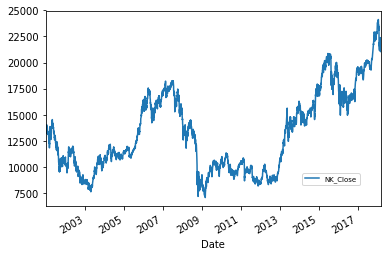

,NK_Close
count,4212.000000
mean,13258.716387
std,3830.598834
min,7054.980000
25%,9999.692500
50%,12241.785000
75%,16313.537500
max,24124.150000


In [2]:
# 学習データの読み込み
df = pd.read_csv('mktdat_nk1.csv',encoding='utf-8',index_col='Date', parse_dates=[0])

#データ確認
df.head() 
df.plot()
plt.legend(bbox_to_anchor=(1, 0), loc='lower right', borderaxespad=3, fontsize=7)
plt.show()
df.describe()

### データ加工

In [3]:
#増減率（100＊log（前日比））を計算し、新たな列を追加

for i in range(len(df.columns)):
    use_col = df.columns[i]
    df[use_col] =  100*np.log(df[use_col]/df[use_col].shift())
            
#前日比をとったので、先頭行にNaNが含まれるため、先頭行を削除
df=df.dropna(how='any')

In [4]:
df.describe()

,NK_Close
count,4211.000000
mean,0.010138
std,1.523779
min,-12.111026
25%,-0.728694
50%,0.042793
75%,0.826839
max,13.234585


In [5]:
#日経平均終値の増減率を4パターンに分類
df['NK_Close_P1'] = df['NK_Close'] >=1  
df['NK_Close_P2'] =  (0 == df['NK_Close']) | (0 < df['NK_Close']) & (df['NK_Close']<1)
df['NK_Close_P3'] =  (-1<= df['NK_Close']) & (df['NK_Close']<0)
df['NK_Close_P4'] = df['NK_Close']<-1

df['NK_Close_P1'] = df['NK_Close_P1'].astype(np.int)
df['NK_Close_P2'] = df['NK_Close_P2'].astype(np.int)
df['NK_Close_P3'] = df['NK_Close_P3'].astype(np.int)
df['NK_Close_P4'] = df['NK_Close_P4'].astype(np.int)
df.head()

,NK_Close,NK_Close_P1,NK_Close_P2,NK_Close_P3,NK_Close_P4
Date,,,,,
2001-01-09,-1.871362,0,0,0,1
2001-01-10,-1.315398,0,0,0,1
2001-01-11,-1.739042,0,0,0,1
2001-01-12,1.104920,1,0,0,0
2001-01-15,1.180398,1,0,0,0


In [6]:
# 学習データ
x_data = np.array(df.iloc[:,0:(len(df.columns)-4)].astype(np.float))

# ラベルデータ（増減率４パターン）
y_data = np.array(df.iloc[:,(len(df.columns)-4):].astype(np.float)) 

In [7]:
maxlen = 80              # 入力系列数
n_in = x_data.shape[1]   # 学習データ（＝入力）の列数
print("n_in:",n_in)
n_out = y_data.shape[1]  # ラベルデータ（=出力）の列数
print("n_out:",n_out)
len_seq = x_data.shape[0] - maxlen
print("x_data.shape[0]:",x_data.shape[0])
print("len_seq:",len_seq)

data = []
target = []
for i in range(0, len_seq):
  data.append(x_data[i:i+maxlen, :]) #80個ずつずらして取得
  target.append(y_data[i+maxlen, :])#80個目から取得

print("len(data):",len(data))
x = np.array(data).reshape(len(data), maxlen)
y = np.array(target).reshape(len(data), n_out)

print("x.shape:",x.shape, "y.shape:",y.shape)

n_in: 1
n_out: 4
x_data.shape[0]: 4211
len_seq: 4131
len(data): 4131
x.shape: (4131, 80) y.shape: (4131, 4)


In [8]:
%%time

#データを学習用とテスト用に分割 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1234)

print("X_train=",X_train)
print()
print("X_test=",X_test)
print()
print("y_train=",y_train)
print()
print("y_test=",y_test)

X_train= [[ 0.48668182 -0.30365328 -0.68869889 ...  1.91719104 -0.27941667
  -0.64113167]
 [-0.13651879 -0.7493772  -1.42014304 ...  0.33662166  1.23295039
   0.38061068]
 [ 1.19926898 -2.24192006  3.68736392 ... -5.04475875  2.54531856
   0.32389183]
 ...
 [-1.8591547  -1.64462762  1.9552206  ... -1.68245109  0.42408237
  -1.79506898]
 [ 3.10870451 -2.11130176 -1.757636   ...  0.60525537 -1.62637338
   1.21295327]
 [ 0.00864036  2.17736046 -0.02570314 ...  0.69697591  2.77896715
  -0.83713081]]

X_test= [[ 1.93126133 -0.13651879 -0.7493772  ... -0.22839983  0.33662166
   1.23295039]
 [ 0.08134466  1.79668717 -0.67525566 ... -0.06833111 -0.99545849
  -2.1103646 ]
 [ 1.96213113  0.9106024   1.12463179 ...  0.09263652 -0.76536134
  -1.18549352]
 ...
 [ 0.69666598  0.67835     0.12277325 ... -0.47287383  0.56519524
  -1.07077471]
 [ 0.78540366 -1.43921153 -1.88092882 ... -0.02518381 -1.52433828
  -0.90425317]
 [-0.23217647 -0.65249021  0.74436331 ... -0.36421275 -1.21721629
   1.74081785]

In [9]:
model = Sequential()
model.add(Dense(80, activation='relu', input_dim=80))
model.add(Dropout(0.1))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(4, activation='softmax'))#最終層のactivationは変更しないこと
   
#sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)    
rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)

model.compile(loss='categorical_crossentropy',
              optimizer=rms,
              metrics=['accuracy'])

Train on 3717 samples, validate on 414 samples
Epoch 1/100
3717/3717 [==============================] - 0s - loss: 1.4281 - acc: 0.2932 - val_loss: 1.3907 - val_acc: 0.2971
Epoch 2/100
3717/3717 [==============================] - 0s - loss: 1.3741 - acc: 0.3099 - val_loss: 1.3780 - val_acc: 0.2681
Epoch 3/100
3717/3717 [==============================] - 0s - loss: 1.3786 - acc: 0.3183 - val_loss: 1.3644 - val_acc: 0.3068
Epoch 4/100
3717/3717 [==============================] - 0s - loss: 1.3772 - acc: 0.3231 - val_loss: 1.4123 - val_acc: 0.3140
Epoch 5/100
3717/3717 [==============================] - 0s - loss: 1.3632 - acc: 0.3355 - val_loss: 1.4226 - val_acc: 0.3092
Epoch 6/100
3717/3717 [==============================] - 0s - loss: 1.3642 - acc: 0.3417 - val_loss: 1.5626 - val_acc: 0.2995
Epoch 7/100
3717/3717 [==============================] - 0s - loss: 1.3643 - acc: 0.3384 - val_loss: 1.4759 - val_acc: 0.2681
Epoch 8/100
3717/3717 [==============================] - 0s - loss: 1.3

3717/3717 [==============================] - 0s - loss: 1.5629 - acc: 0.3742 - val_loss: 2.2710 - val_acc: 0.2971
Epoch 66/100
3717/3717 [==============================] - 0s - loss: 1.4695 - acc: 0.3761 - val_loss: 1.9480 - val_acc: 0.3019
Epoch 67/100
3717/3717 [==============================] - 0s - loss: 1.4409 - acc: 0.3740 - val_loss: 2.0614 - val_acc: 0.2729
Epoch 68/100
3717/3717 [==============================] - 0s - loss: 1.4933 - acc: 0.3780 - val_loss: 2.0570 - val_acc: 0.2246
Epoch 69/100
3717/3717 [==============================] - 0s - loss: 1.5294 - acc: 0.3818 - val_loss: 2.0217 - val_acc: 0.3019
Epoch 70/100
3717/3717 [==============================] - 0s - loss: 1.5051 - acc: 0.3707 - val_loss: 2.0131 - val_acc: 0.2899
Epoch 71/100
3717/3717 [==============================] - 0s - loss: 1.4974 - acc: 0.3753 - val_loss: 2.0804 - val_acc: 0.2778
Epoch 72/100
3717/3717 [==============================] - 0s - loss: 1.5132 - acc: 0.3820 - val_loss: 2.1528 - val_acc: 0.27

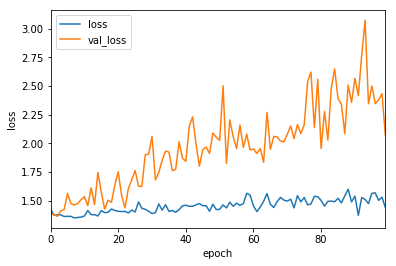

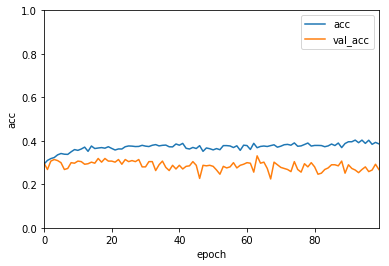

In [10]:
# 学習
fit = model.fit(X_train, y_train,
          epochs=100,
          batch_size=10,validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

In [12]:
#テスト
score = model.evaluate(X_test, y_test, batch_size = 10, verbose = 1)
print("score:", score)

#識別率（騰落４分類）
y_pred = model.predict(X_test)
correct = 0
semi_correct = 0
for i in range(len(y_pred)):
  pred = np.argmax(y_pred[i,:])
  tar = np.argmax(y_test[i,:])
  if pred == tar :
    correct += 1
  else :
    if pred+tar == 1 or pred+tar == 5 :
      semi_correct += 1

print("識別率（騰落４分類）: %6.5f" % (1.0 * correct / len(y_pred)))
print("識別率（騰落）: %6.5f" % (1.0 * (correct+semi_correct) / len(y_pred)))

 10/414 [..............................] - ETA: 4sscore: [2.0679016430020907, 0.2681159483277855]
識別率（騰落４分類）: 0.26812
識別率（騰落）: 0.53140
